# Explainability Lab - Credit Risk

<img src=https://mma.prnewswire.com/media/1715842/HeadMind_Partners_Logo.jpg width="500">

<img src=https://www.centralesupelec.fr/sites/all/themes/cs_theme/medias/common/images/intro/logo.png width="500">

*Context*

Credit risk is the risk that a customer doesn't pay back the money he borrowed from a bank. Banks do credit risk modelling to minimize their expected credit loss. ML models can be trained to classify whether a customer is at risk or not. (The banking sector is quite an early adopter of AI compared to other sectors). But banks have to comply with regulations that force them to provide models outputs with explanations that humans can understand.

*Dataset*

The German Credit Risk <a href="https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29"> dataset </a> is used.

The dataset is anonymized because it contains information about customer which is sensitive. The features are described in the data/features.txt file.

*Objectives*

- Dataset exploration : use seaborn to find relevant correlations
- ML implementation : train a Random Forest Classifier with Optuna 
- Explainability : global and local feature importance. Introduction to SHAP, LIME and ICE

*Notebook made by Headmind Partners AI & Blockchain*

## Libraries

In [33]:
#!pip install -r requirements.txt

In [28]:
import pickle
import shap
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from scipy import stats
import optuna
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image
pd.set_option("display.max_columns", 500)

In [29]:
import mlflow

## Data Exploration

In [51]:
PATH = "data/credit-g.pkl"

with open(PATH, 'rb') as read_file:
    df = pickle.load(read_file)
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,description
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,good,rpimcehosa
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,bad,lzrdxtilff
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,good,uqhvkwayzt
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes,good,xoedxpdzgm
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes,bad,yxyrmgoqzn


The goal is to predict if a bank can give a credit to a customer according to its profile

Question: Identify the target field

In [52]:
# Identify target field
#########################
# target_field = "..."
target_field = "class"
#########################

In [53]:
# Let's rename the target field
df.rename(columns={target_field:'risk'},inplace=True)
# And change the label values 
df['risk'] = df['risk'].map({'good':0,'bad':1})

y = df['risk']
X = df.drop(columns=['risk'])

This is a binary classification problem where
-  y = 1 if the customer is at risk
-  y = 0 if the customer is "bankable"

In real life banks assess customer risk with more than two values (risky or not risky).

In our case, what trick would you propose to get n risk values (with n>2) ? (with probabilities for instance)

--------------------------
ANSWER HERE

--------------------------

### Using seaborn to explore data 

Correlation matrixes and features distributions according to the credit risk are displayed using the *seaborn* library.

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

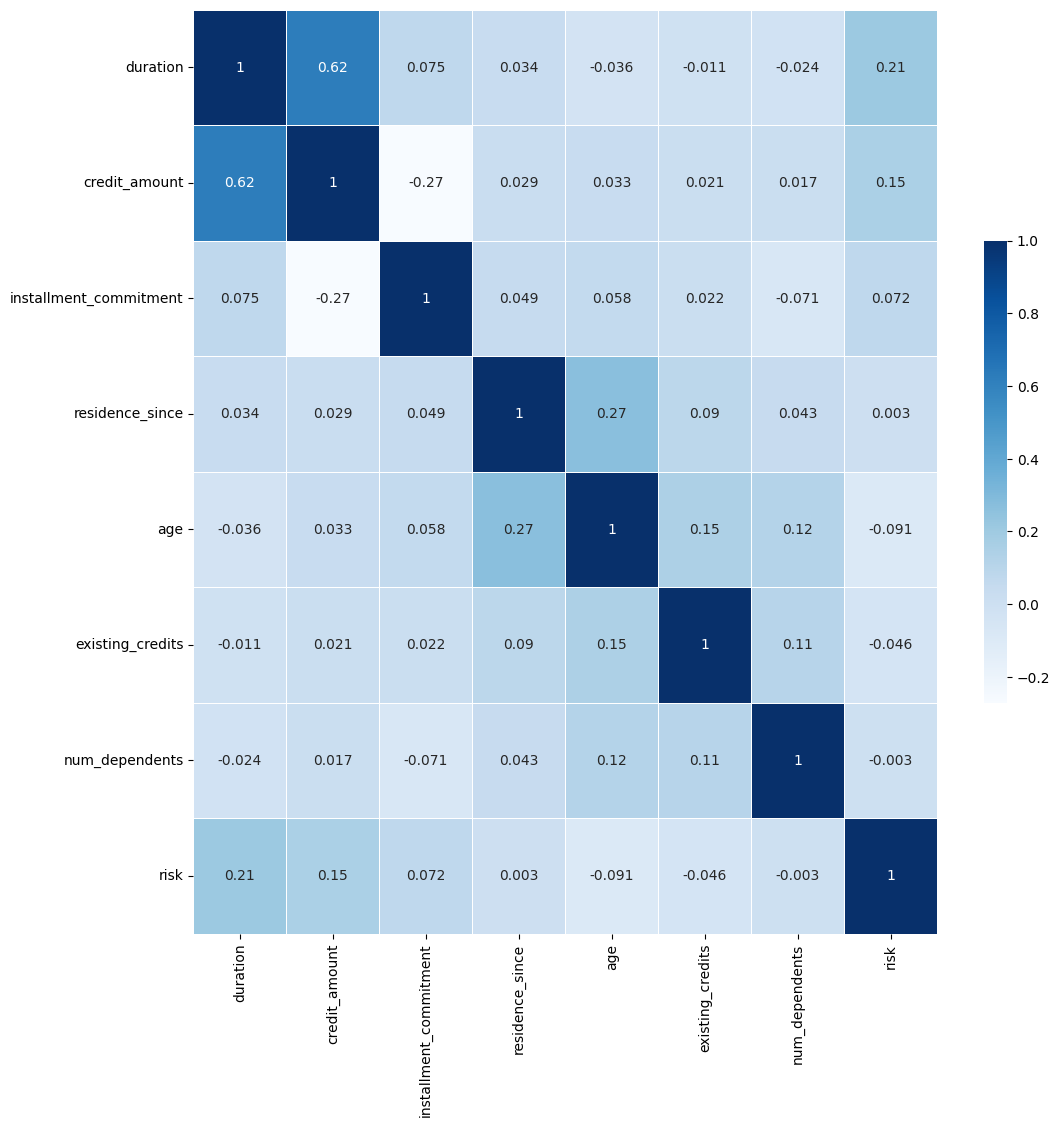

In [33]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, cmap="Blues", annot=True, linewidths=.5, cbar_kws={"shrink": .5})

## Encoding

Preliminary data exploration helped us discover all the features in the dataset, their distributions and correlations.

The categorical features now have to be encoded

In [54]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_feat = X.select_dtypes(include=numerics).columns.tolist()

##############################################
# Pick the right categorical features to encode
categorical_feat = ["checking_status","credit_history","purpose",'savings_status',"employment","personal_status","other_parties","property_magnitude","other_payment_plans","housing","job","own_telephone","foreign_worker"]
##############################################

onehot_encoder = OneHotEncoder()

# Fit_transform - create a X_enc dataframe from the X dataframe
X_enc_array = onehot_encoder.fit_transform(X[categorical_feat])
X_enc = pd.DataFrame(X_enc_array.toarray(), columns=onehot_encoder.get_feature_names(input_features=categorical_feat))
X_enc[numeric_feat] = X[numeric_feat]

display(X_enc.head())


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car,savings_status_100<=X<500,savings_status_500<=X<1000,savings_status_<100,savings_status_>=1000,savings_status_no known savings,employment_1<=X<4,employment_4<=X<7,employment_<1,employment_>=7,employment_unemployed,personal_status_female div/dep/mar,personal_status_male div/sep,personal_status_male mar/wid,personal_status_male single,other_parties_co applicant,other_parties_guarantor,other_parties_none,property_magnitude_car,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,6,1169,4,4,67,2,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,48,5951,2,2,22,1,1
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,12,2096,2,3,49,1,2
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,42,7882,2,4,45,1,2
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,24,4870,3,4,53,2,2


In [55]:
with open("encoders/one_hot_encoder.pkl", 'wb') as file:
    pickle.dump(onehot_encoder, file)

## ML Modeling

### Train/test split

Question : Split X and y to fit the model. Make sure the risk proportion in the train set are the same as in the test set using the argument *stratify*.

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X_enc,y,test_size=0.2, stratify=y, random_state=16)

### Training a ML model
A Ramdom Forest is a right model to be trained on a small dataset (1000 rows)

#### Random Forest

Question : Do you consider the dataset unbalanced ? Compute the label proportion. Do you think it is necessary to add class weight or sample weight ?

In [57]:
# No optimization

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [58]:
from sklearn.metrics import roc_auc_score, f1_score

mlflow.set_experiment(experiment_name="finetune-creditrisk")
with mlflow.start_run(run_name="RandomForest_NoOptimization"):
    # log params
    params = rf_clf.get_params()
    mlflow.log_param("n_estimators", params["n_estimators"])
    mlflow.log_param("bootstrap", params["bootstrap"])
    mlflow.log_param("min_samples_leaf", params["min_samples_leaf"])
    mlflow.log_param("max_depth", params["max_depth"])

    # log metrics
    y_pred = rf_clf.predict_proba(X_test)[:,1]
    mlflow.log_metric("auc", roc_auc_score(y_test,y_pred))
    mlflow.log_metric("f1-score", f1_score(y_test, rf_clf.predict(X_test)))
    
    mlflow.sklearn.log_model(rf_clf, artifact_path="sklearn-model",
        registered_model_name="sk-learn-random-forest")
    
    mlflow.log_artifact(local_path='encoders/one_hot_encoder.pkl', artifact_path="")

Registered model 'sk-learn-random-forest' already exists. Creating a new version of this model...
2023/04/18 17:40:47 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sk-learn-random-forest, version 7
Created version '7' of model 'sk-learn-random-forest'.


In [59]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify = y_train, random_state=16)

def objective_rf(trial):
    rf_params = {
            # Parameter space definition
            #################################################################
            'n_estimators' : trial.suggest_int('n_estimators',low=50,high=250),
            'max_depth' : trial.suggest_int('max_depth',low=2,high=10),
            'max_features' : trial.suggest_categorical('max_features', ["sqrt", None]),
            'min_samples_leaf' : trial.suggest_float("min_samples_leaf", low = 0.001, high = 0.1)
            #################################################################
            }

    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.set_params(**rf_params)

    rf_classifier.fit(X_train, y_train)

    # Log metrics
    y_pred = rf_classifier.predict(X_val)
    score=f1_score(y_val, y_pred)
    mlflow.log_metric("auc", roc_auc_score(y_val,y_pred))
    mlflow.log_metric("f1-score", score)
    return score

In [60]:
study = optuna.create_study(direction="maximize")
full_objective = lambda trial: objective_rf(trial)
mlflow.set_experiment(experiment_name="finetune-creditrisk")
with mlflow.start_run(run_name="RandomForest_Finetuning_exp"):
    study.optimize(full_objective, n_trials=30, timeout=600)
rf_params = study.best_trial.params

[I 2023-04-18 17:50:21,344] A new study created in memory with name: no-name-3a09dc85-9c9e-482c-86fd-6986fe035ff5
[I 2023-04-18 17:50:21,773] Trial 0 finished with value: 0.11538461538461539 and parameters: {'n_estimators': 183, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.027563295319195692}. Best is trial 0 with value: 0.11538461538461539.
[I 2023-04-18 17:50:22,214] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 221, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.08640426442115025}. Best is trial 0 with value: 0.11538461538461539.
[I 2023-04-18 17:50:22,871] Trial 2 finished with value: 0.3142857142857143 and parameters: {'n_estimators': 210, 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 0.07381814541424812}. Best is trial 2 with value: 0.3142857142857143.
[I 2023-04-18 17:50:23,046] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 76, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.0171963

In [61]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.set_params(**rf_params)

X_train_val, y_train_val = pd.concat((X_train, X_val)), pd.concat((y_train, y_val))

rf_classifier.fit(X_train_val, y_train_val)
with mlflow.start_run(run_name="RandomForest_Optimization"):
    # log params
    mlflow.log_param("n_estimators", rf_params["n_estimators"])
    mlflow.log_param("min_samples_leaf", rf_params["min_samples_leaf"])
    mlflow.log_param("max_depth", rf_params["max_depth"])
    mlflow.log_param('max_features', rf_params['max_features'])

    # log metrics
    y_pred = rf_classifier.predict_proba(X_test)[:,1]
    mlflow.log_metric("auc", roc_auc_score(y_test,y_pred))
    mlflow.log_metric("f1-score", f1_score(y_test, rf_classifier.predict(X_test)))
    
    mlflow.sklearn.log_model(rf_clf, artifact_path="sklearn-model",
        registered_model_name="sk-learn-random-forest-finetuned")
    mlflow.log_artifact(local_path='encoders/one_hot_encoder.pkl', artifact_path="")

Registered model 'sk-learn-random-forest-finetuned' already exists. Creating a new version of this model...
2023/04/18 17:52:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sk-learn-random-forest-finetuned, version 5
Created version '5' of model 'sk-learn-random-forest-finetuned'.


# Retrieves a model logged on MLFlow - on run_id

In [20]:
import mlflow
from IPython.display import display

experiment_name = ["finetune-creditrisk"]
run_name = "RandomForest_Optimization"

# Search for the run using the experiment name and run name
runs = mlflow.search_runs(experiment_names=experiment_name)

display(runs)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.auc,metrics.f1-score,params.max_features,params.max_depth,params.min_samples_leaf,params.n_estimators,params.bootstrap,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user
0,2519bca697814149addac43cc5add1c2,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-18 14:37:32.188000+00:00,2023-04-18 14:37:37.290000+00:00,0.772738,0.568807,None,9,0.004854998700106793,195,None,RandomForest_Optimization,"[{""run_id"": ""2519bca697814149addac43cc5add1c2""...",LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand
1,7ac3fbd990f14b31ba01aeb46f155982,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-18 14:36:12.131000+00:00,2023-04-18 14:36:34.051000+00:00,0.598214,0.418605,None,None,None,None,None,RandomForest_Finetuning_exp,None,LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand
2,16ae00a4932e4ca9a951105eeb1b6ea8,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-18 14:33:20.631000+00:00,2023-04-18 14:33:26.118000+00:00,0.777857,0.461538,None,None,1,100,True,RandomForest_NoOptimization,"[{""run_id"": ""16ae00a4932e4ca9a951105eeb1b6ea8""...",LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand
3,b48a46a0aa5743eaabae338b4d3e0905,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-18 14:31:29.073000+00:00,2023-04-18 14:31:34.032000+00:00,0.777976,0.536082,None,None,1,100,True,RandomForest_NoOptimization,"[{""run_id"": ""b48a46a0aa5743eaabae338b4d3e0905""...",LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand
4,3ca76b7bc7604b238df20415aa53c3ec,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-18 07:57:21.713000+00:00,2023-04-18 07:57:26.941000+00:00,0.800893,0.414634,None,None,1,100,True,RandomForest_NoOptimization,"[{""run_id"": ""3ca76b7bc7604b238df20415aa53c3ec""...",LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand
5,1229383a8ebd458a9684bc04d25d4c91,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-17 14:04:41.274000+00:00,2023-04-17 14:04:45.791000+00:00,0.745357,0.546667,sqrt,9,0.08715398429018674,73,None,RandomForest_Optimization,"[{""run_id"": ""1229383a8ebd458a9684bc04d25d4c91""...",LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand
6,8be95ffd4b39462c90e8114fb624ea3d,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-17 14:04:31.557000+00:00,2023-04-17 14:04:38.611000+00:00,0.623636,0.516129,None,None,None,None,None,RandomForest_Finetuning_exp,None,LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand
7,7f2c13f3e6814777965e8dc813c814b3,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-17 14:02:50.367000+00:00,2023-04-17 14:02:54.460000+00:00,0.759167,0.567568,sqrt,5,0.024061268413336525,243,None,RandomForest_Optimization,"[{""run_id"": ""7f2c13f3e6814777965e8dc813c814b3""...",LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand
8,89a3ebd6a1c64937b24444a3022c1a08,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-17 14:02:34.011000+00:00,2023-04-17 14:02:43.877000+00:00,0.693452,0.576271,None,None,None,None,None,RandomForest_Finetuning_exp,None,LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand
9,3dcd9611630743f4976a743726c7ee73,858524302955933687,FINISHED,file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow...,2023-04-17 14:02:06.897000+00:00,2023-04-17 14:02:14.368000+00:00,0.633929,0.521739,None,None,None,None,None,RandomForest_Finetuning_exp,None,LOCAL,c:\Users\rgrand\OpenMind\MLFlow\MLFlow_on_XAI\...,rgrand


In [21]:
last_run_id = runs.loc[runs["tags.mlflow.runName"] == run_name]
last_run_id.sort_values(by = ["end_time"], ascending=False, inplace=True)
run_id = last_run_id.iloc[0]["run_id"]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
# Retrieves a model from MLFlow
model = mlflow.sklearn.load_model(f"runs:/{run_id}/sklearn-model")
model.predict(X_test)

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0], dtype=int64)

# Upgrades the model status

In [63]:
from mlflow import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
    name="sk-learn-random-forest-finetuned", version=5, stage="Production"
)

<ModelVersion: creation_timestamp=1681833121165, current_stage='Production', description=None, last_updated_timestamp=1681833371553, name='sk-learn-random-forest-finetuned', run_id='cd3cad9a903547ae85c5df6fafb6d8cf', run_link=None, source='file:///c:/Users/rgrand/OpenMind/MLFlow/MLFlow_on_XAI/mlruns/858524302955933687/cd3cad9a903547ae85c5df6fafb6d8cf/artifacts/sklearn-model', status='READY', status_message=None, tags={}, user_id=None, version=5>

# Retrieves the model from the status

In [64]:
import mlflow

model_name = "sk-learn-random-forest-finetuned"
model_version = 5

model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{model_version}")